# Infection Simulation


In [6]:
import datetime as dt
import random

import matplotlib.pyplot as plt
import popy as popy
from popy.data_fakers.soep import soep_faker
from popy.pop_maker import PopMaker
import popy.utils as utils

In [7]:
class Agent(popy.Agent):
    def __init__(self, model, *args, **kwargs):
        super().__init__(model, *args, **kwargs)

        self.infection_status = "susceptible"
        self.days_since_infection = 0

    def infect(self):
        if self.infection_status in ["infectious", "symptomatic"]:
            for agent_v in self.neighbors():
                if agent_v.infection_status == "susceptible":
                    contact_weight = self.contact_weight(agent_v)
                    infection_probability = self.model.p.infection_weight * contact_weight

                    if random.random() < infection_probability:
                        agent_v.infection_status = "exposed"

    def update_infection_status(self):
        if self.infection_status in ["exposed", "infectious", "symptomatic"]:
            self.days_since_infection += 1

            if 2 <= self.days_since_infection <= 5:
                self.infection_status = "infectious"

            elif 6 <= self.days_since_infection <= 10:
                self.infection_status = "symptomatic"

            elif self.days_since_infection >= 11:
                self.infection_status = "recovered"

In [8]:
class Home(popy.Location):
    def setup(self) -> None:
        self.weight_projection_denominator = 24

    def group(self, agent):
        return agent.hid

    def weight(self, agent):  # noqa: ARG002
        return 8


class Work(popy.Location):
    def setup(self):
        self.size = 10
        self.weight_projection_denominator = 24

    def join(self, agent):
        return agent.work_hours_day > 0

    def weight(self, agent):
        return agent.work_hours_day


class School(popy.Location):
    def setup(self):
        self.size = 25
        self.weight_projection_denominator = 24

    def join(self, agent) -> bool:
        return 6 <= agent.age <= 18

    def weight(self, agent):
        weight = 0

        # workday?
        if agent.model.date.weekday() < 5:
            # not ill?
            if (
                agent.infection_status != "symptomatic"
                or agent.infection_status == "symptomatic"
                and random.random() < 0.5
            ):
                # no holidays?
                if random.random() < self.model.get_timetable_entry()["school"]:
                    weight = 6

        return weight


class Friendship(popy.Location):
    def setup(self):
        self.size = 2
        self.weight_projection_denominator = 24

    def group(self, agent):
        return (abs(agent.age + random.randint(-5, 5)), agent.gender)

    def weight(self, agent):
        return 2 if agent.model.date.weekday() >= 5 else 0

In [9]:
class Model(popy.Model):
    def setup(self):
        self.date = dt.date(2022, 1, 1)
        df_soep = soep_faker.soep(size=self.p.n_agents)
        self.pop_maker = PopMaker(model=self)
        self.agents, self.locations = self.pop_maker.make(
            df=df_soep,
            agent_class=Agent,
            location_classes=[Home, School, Work, Friendship],
        )
        self.infection_list = []

        for agent in random.choices(self.agents, k=10):
            agent.infection_status = "exposed"

        self.timetable = {
            dt.date(2020, 1, 1): {
                "school": 1,
            },
            dt.date(2020, 2, 1): {
                "school": 0,
            },
            dt.date(2020, 2, 15): {
                "school": 1,
            },
        }

    def step(self):
        self.agents.update_infection_status()
        self.agents.infect()

    def update(self):
        self.record(
            "cumulative_infections",
            sum([1 for agent in self.agents if agent.infection_status != "susceptible"]),
        )
        self.date = self.date + dt.timedelta(days=1)

    def get_timetable_entry(self):
        for date_key in self.timetable:
            if date_key <= self.date:
                entry = self.timetable[date_key]
        return entry

Completed: 50 steps
Run time: 0:00:01.164945
Simulation finished


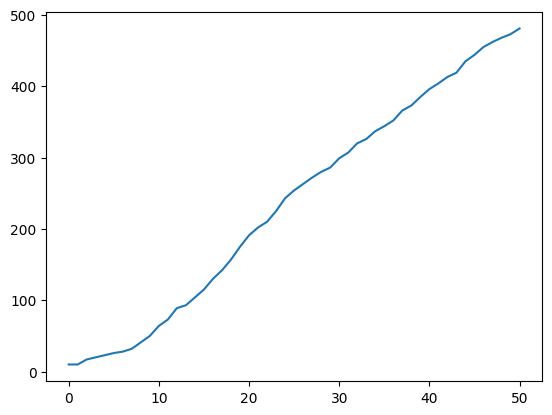

In [10]:
parameters = {
    "steps": 50,
    "n_agents": 1000,
    "infection_weight": 0.5,
}
model = Model(parameters=parameters)

results = model.run()

plt.plot(results.variables.Model.cumulative_infections)

In [11]:
model.pop_maker.eval_affiliations()



______________________________________
Number of agents per location
______________________________________

               n_agents                                                    
                  count       mean       std   min    25%   50%   75%   max
location_class                                                             
Friendship        545.0   1.937615  0.517841   0.0   2.00   2.0   2.0   3.0
Home              344.0   2.906977  1.339056   1.0   2.00   3.0   4.0   8.0
School              4.0  26.750000  0.500000  26.0  26.75  27.0  27.0  27.0
Work               41.0   9.902439  0.624695   6.0  10.00  10.0  10.0  10.0


______________________________________
Number of affiliated locations per agent
______________________________________

count    1000.000000
mean        2.569000
std         1.095646
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         7.000000
Name: n_affiliated_locations, dtype: float64


,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95
95,0.000,0.003,0.002,0.005,0.013,0.016,0.020,0.009,0.019,0.015,0.019,0.016,0.019,0.014,0.013,0.015,0.006,0.018,0.027,0.024
90,0.001,0.004,0.004,0.005,0.017,0.011,0.011,0.013,0.018,0.011,0.016,0.016,0.026,0.017,0.012,0.018,0.010,0.022,0.028,0.027
85,0.001,0.008,0.003,0.008,0.018,0.016,0.016,0.016,0.024,0.022,0.019,0.013,0.013,0.011,0.017,0.013,0.015,0.028,0.022,0.018
80,0.001,0.002,0.006,0.002,0.013,0.007,0.006,0.011,0.012,0.009,0.017,0.016,0.013,0.015,0.015,0.026,0.024,0.015,0.010,0.006
75,0.005,0.008,0.012,0.003,0.023,0.013,0.013,0.010,0.014,0.012,0.027,0.019,0.018,0.028,0.032,0.026,0.026,0.013,0.018,0.015
70,0.003,0.002,0.007,0.009,0.022,0.012,0.023,0.030,0.034,0.019,0.024,0.021,0.035,0.036,0.058,0.032,0.015,0.017,0.012,0.013
65,0.003,0.004,0.007,0.005,0.026,0.021,0.017,0.027,0.034,0.021,0.029,0.032,0.039,0.050,0.036,0.028,0.015,0.011,0.017,0.014
60,0.000,0.006,0.008,0.014,0.025,0.021,0.037,0.033,0.040,0.026,0.036,0.049,0.056,0.039,0.035,0.018,0.013,0.013,0.026,0.019
55,0.002,0.010,0.004,0.009,0.019,0.016,0.024,0.027,0.033,0.023,0.043,0.048,0.049,0.032,0.021,0.019,0.016,0.013,0.016,0.016
50,0.001,0.006,0.005,0.005,0.030,0.024,0.020,0.020,0.046,0.029,0.068,0.043,0.036,0.029,0.024,0.027,0.017,0.019,0.016,0.019


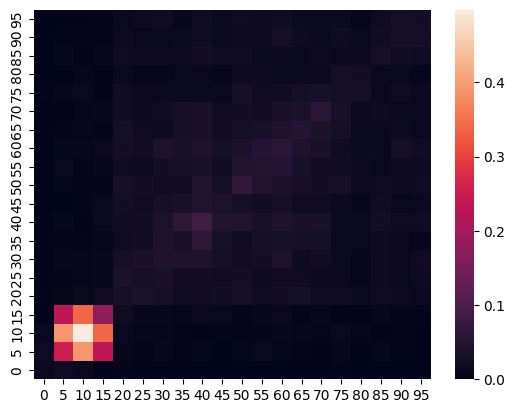

In [12]:
for agent in model.agents:
    agent.age_5 = utils.group_it(
        agent.age,
        start=0,
        step=5,
        n_steps=20,
        return_value="lower_bound",
    )

utils.create_contact_matrix(model.agents, attr="age_5", plot=True)